In [0]:
! git clone https://github.com/cggcaio/Anomaly-Detection-for-Driver-Identification.git

Cloning into 'Anomaly-Detection-for-Driver-Identification'...
remote: Enumerating objects: 181, done.
remote: Counting objects: 100% (181/181), done.
remote: Compressing objects: 100% (100/100), done.
remote: Total 181 (delta 71), reused 169 (delta 62), pack-reused 0
Receiving objects: 100% (181/181), 51.26 MiB | 8.04 MiB/s, done.
Resolving deltas: 100% (71/71), done.
Checking out files: 100% (29/29), done.


In [0]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import OneClassSVM
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import gzip
import pandas as pd

Filtering out the anomalies and the normal data points to construct a new data set that is a mixture of the two

In [0]:
  columns = ["duration", "protocol_type", "service", "flag", "src_bytes",
"dst_bytes", "land", "wrong_fragment", "urgent",
    "hot", "num_failed_logins", "logged_in", "num_compromised",
"root_shell", "su_attempted", "num_root",
    "num_file_creations", "num_shells", "num_access_files",
"num_outbound_cmds", "is_host_login",
    "is_guest_login", "count", "srv_count", "serror_rate",
"srv_serror_rate", "rerror_rate", "srv_rerror_rate",
    "same_srv_rate", "diff_srv_rate", "srv_diff_host_rate",
"dst_host_count", "dst_host_srv_count",
    "dst_host_same_srv_rate", "dst_host_diff_srv_rate",
"dst_host_same_src_port_rate", "dst_host_srv_diff_host_rate",
    "dst_host_serror_rate", "dst_host_srv_serror_rate",
"dst_host_rerror_rate", "dst_host_srv_rerror_rate", "label"]

with gzip.open('/content/Anomaly-Detection-for-Driver-Identification/Methods/kddcup.data.gz', 'rb') as f:
    df = pd.read_csv(f, sep=",", names=columns, index_col=None)
    
    
    df = df[df["service"] == "http"]
    df = df.drop("service", axis=1)
    columns.remove("service")

    novelties = df[df["label"] != "normal."]
    novelties_normal = df[150000:154045]

    novelties = pd.concat([novelties, novelties_normal])
    normal = df[df["label"] == "normal."]

    print(novelties.shape)
    print(normal.shape)
   

(8090, 41)
(619046, 41)


Encoding all the categorical values in the data frames

In [0]:
for col in normal.columns:  
  if normal[col].dtype == "object":
    encoded = LabelEncoder()
    encoded.fit(normal[col])
    normal[col] = encoded.transform(normal[col])

for col in novelties.columns:
  if novelties[col].dtype == "object":
    encoded2 = LabelEncoder()
    encoded2.fit(novelties[col])
    novelties[col] = encoded2.transform(novelties[col]) 
  

Set up training, testing and validation sets

In [0]:
for f in range(0,10):
  normal = normal.iloc[np.random.permutation(len(normal))]


df2 = pd.concat([normal[:100000], normal[200000:250000]])
df_validate = normal[100000:150000]
x_train, x_test=train_test_split(df2, test_size = 0.2, random_state = 42)
x_val = df_validate

In [0]:
print("x_train:{}\n" .format(x_train.shape))
print("x_test:{}\n" .format(x_test.shape))
print("x_validation:{}\n" .format(x_val.shape))

x_train:(120000, 41)

x_test:(30000, 41)

x_validation:(50000, 41)



Declaring and initializing the model

In [0]:
ocsvm = OneClassSVM(kernel='rbf', gamma=0.00005 , nu=0.1)

# kernel (default rbf = radial basis function)
# gamma tells the model how much you want to consider points further from the hyperplane. Since it is pretty small, this means you want to emphasize the points farther away. 
# nu tells the model approximately how many data points you expect the model to misclassify.

Training the model on the training data

In [0]:
ocsvm.fit(x_train)

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma=5e-05, kernel='rbf',
            max_iter=-1, nu=0.1, shrinking=True, tol=0.001, verbose=False)

Making predictions and generating the accuracy score

In [0]:
preds = ocsvm.predict(x_test)
score = 0
for f in range(0, x_test.shape[0]):
  if(preds[f] == 1):
    score = score+1

accuracy = score / x_test.shape[0]
print("Accuracy: {:.2%}".format(accuracy))

Accuracy: 89.75%


Generating the accuracy score for the validation set

In [0]:
preds = ocsvm.predict(x_val)
score = 0
for f in range(0, x_val.shape[0]):
  if(preds[f] == 1):
    score = score+1

accuracy = score / x_val.shape[0]
print("Accuracy: {:.2%}".format(accuracy))

Accuracy: 89.74%


Generating the AUC score

In [0]:
from sklearn.metrics import roc_auc_score

preds = ocsvm.predict(novelties)
matches = novelties["label"] == 4

auc = roc_auc_score(preds, matches)
print("AUC: {:.2%}".format (auc))

AUC: 95.99%


Code to display a graph that shows the distributions for the predictions

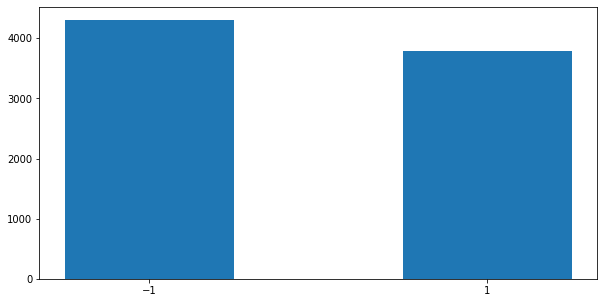

In [17]:
plt.figure(figsize=(10,5))
plt.hist(preds, bins=[-1.5, -0.5] + [0.5, 1.5], align='mid')
plt.xticks([-1, 1])
plt.show()
